# Imports

In [1]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Set up arguments for datasets, models and training.

In [2]:
args = {
    "task" : "link_prediction",
    
    "dataset" : "IAEnronEmployees",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges",
    "mode" : "train",
    "generate_neg_examples" : True,
    
    "duplicate_examples" : True,
    "repeat_examples" : False,
    
    "self_loop" : False,
    "normalize_adj" : False,
    
    "cuda" : "True",
    "model" : "GraphSAGE",
    "agg_class" : "MaxPoolAggregator",
    "hidden_dims" : [64],
    "dropout" : 0.5,
    "num_samples" : -1,
    
    "epochs" : 3,
    "batch_size" : 32,
    "lr" : 1e-4,
    "weight_decay" : 5e-4,
    "stats_per_batch" : 3,
    "visdom" : True,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
config['device'] = device

# Get the dataset, dataloader and model.

In [3]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'train',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: train
Number of vertices: 151
Number of static edges: 759
Number of temporal edges: 15171
Number of examples/datapoints: 19166
--------------------------------


In [4]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()
config['input_dim'], config['output_dim'] = input_dim, output_dim

In [5]:
model = utils.get_model(config)
print(model)

GraphSAGE(
  (aggregators): ModuleList(
    (0): MaxPoolAggregator(
      (fc1): Linear(in_features=151, out_features=151, bias=True)
      (relu): ReLU()
    )
    (1): MaxPoolAggregator(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=302, out_features=64, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)


# Compute ROC-AUC score for the untrained model.

In [6]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset before training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset before training.
    Batch 1 / 599
    Batch 2 / 599
    Batch 3 / 599
    Batch 4 / 599
    Batch 5 / 599
    Batch 6 / 599
    Batch 7 / 599
    Batch 8 / 599
    Batch 9 / 599
    Batch 10 / 599
    Batch 11 / 599
    Batch 12 / 599
    Batch 13 / 599
    Batch 14 / 599
    Batch 15 / 599
    Batch 16 / 599
    Batch 17 / 599
    Batch 18 / 599
    Batch 19 / 599
    Batch 20 / 599
    Batch 21 / 599
    Batch 22 / 599
    Batch 23 / 599
    Batch 24 / 599
    Batch 25 / 599
    Batch 26 / 599
    Batch 27 / 599
    Batch 28 / 599
    Batch 29 / 599
    Batch 30 / 599
    Batch 31 / 599
    Batch 32 / 599
    Batch 33 / 599
    Batch 34 / 599
    Batch 35 / 599
    Batch 36 / 599
    Batch 37 / 599
    Batch 38 / 599
    Batch 39 / 599
    Batch 40 / 599
    Batch 41 / 599
    Batch 42 / 599
    Batch 43 / 599
    Batch 44 / 599
    Batch 45 / 599
    Batch 46 / 599
    Batch 47 / 599
    Batch 48 / 59

    Batch 419 / 599
    Batch 420 / 599
    Batch 421 / 599
    Batch 422 / 599
    Batch 423 / 599
    Batch 424 / 599
    Batch 425 / 599
    Batch 426 / 599
    Batch 427 / 599
    Batch 428 / 599
    Batch 429 / 599
    Batch 430 / 599
    Batch 431 / 599
    Batch 432 / 599
    Batch 433 / 599
    Batch 434 / 599
    Batch 435 / 599
    Batch 436 / 599
    Batch 437 / 599
    Batch 438 / 599
    Batch 439 / 599
    Batch 440 / 599
    Batch 441 / 599
    Batch 442 / 599
    Batch 443 / 599
    Batch 444 / 599
    Batch 445 / 599
    Batch 446 / 599
    Batch 447 / 599
    Batch 448 / 599
    Batch 449 / 599
    Batch 450 / 599
    Batch 451 / 599
    Batch 452 / 599
    Batch 453 / 599
    Batch 454 / 599
    Batch 455 / 599
    Batch 456 / 599
    Batch 457 / 599
    Batch 458 / 599
    Batch 459 / 599
    Batch 460 / 599
    Batch 461 / 599
    Batch 462 / 599
    Batch 463 / 599
    Batch 464 / 599
    Batch 465 / 599
    Batch 466 / 599
    Batch 467 / 599
    Batch 468 / 599


# Train.

In [7]:
if not config['load']:
    use_visdom = config['visdom']
    if use_visdom:
        vis = visdom.Visdom()
        loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.8)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 600, 1000, 1400], gamma=0.7)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                print('    Batch {} / {}: loss {:.4f}'.format(
                    idx+1, num_batches, running_loss))
                if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                    area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                    print('    ROC-AUC score: {:.4f}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if use_visdom:
                if loss_window is None:
                    loss_window = vis.line(
                        Y=[loss.item()],
                        X=[epoch*num_batches+idx],
                        opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
                else:
                    vis.line(
                        [loss.item()],
                        [epoch*num_batches+idx],
                        win=loss_window,
                        update='append')
            scheduler.step()
    if use_visdom:
        vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 3
    Batch 3 / 599: loss 0.6933
    ROC-AUC score: 0.4258
    Batch 6 / 599: loss 0.6928
    ROC-AUC score: 0.6235
    Batch 9 / 599: loss 0.6927
    ROC-AUC score: 0.6984
    Batch 12 / 599: loss 0.6928
    ROC-AUC score: 0.6328
    Batch 15 / 599: loss 0.6927
    ROC-AUC score: 0.7341
    Batch 18 / 599: loss 0.6926
    ROC-AUC score: 0.5508
    Batch 21 / 599: loss 0.6930
    ROC-AUC score: 0.5529
    Batch 24 / 599: loss 0.6927
    ROC-AUC score: 0.7229
    Batch 27 / 599: loss 0.6920
    ROC-AUC score: 0.7490
    Batch 30 / 599: loss 0.6920
    ROC-AUC score: 0.7692
    Batch 33 / 599: loss 0.6925
    ROC-AUC score: 0.7085
    Batch 36 / 599: loss 0.6927
    ROC-AUC score: 0.7206
    Batch 39 / 599: loss 0.6922
    ROC-AUC score: 0.6923
    Batch 42 / 599: loss 0.6912
    ROC-AUC score: 0.7897
    Batch 45 / 599: loss 0.6927
    ROC-AUC score: 0.6087
    Batch 48 / 599: loss 0.6919
    ROC-AUC score: 0.6570
    Batch 51 / 599: 

    Batch 423 / 599: loss 0.6242
    ROC-AUC score: 0.8182
    Batch 426 / 599: loss 0.6250
    ROC-AUC score: 0.8016
    Batch 429 / 599: loss 0.6421
    ROC-AUC score: 0.7451
    Batch 432 / 599: loss 0.6518
    ROC-AUC score: 0.5223
    Batch 435 / 599: loss 0.6408
    ROC-AUC score: 0.6039
    Batch 438 / 599: loss 0.6475
    ROC-AUC score: 0.8164
    Batch 441 / 599: loss 0.6227
    ROC-AUC score: 0.6941
    Batch 444 / 599: loss 0.6099
    ROC-AUC score: 0.8320
    Batch 447 / 599: loss 0.6233
    ROC-AUC score: 0.8095
    Batch 450 / 599: loss 0.6077
    ROC-AUC score: 0.8157
    Batch 453 / 599: loss 0.6135
    ROC-AUC score: 0.8281
    Batch 456 / 599: loss 0.6510
    ROC-AUC score: 0.7222
    Batch 459 / 599: loss 0.6486
    ROC-AUC score: 0.8500
    Batch 462 / 599: loss 0.6146
    ROC-AUC score: 0.8611
    Batch 465 / 599: loss 0.5700
    ROC-AUC score: 0.8406
    Batch 468 / 599: loss 0.6273
    ROC-AUC score: 0.6836
    Batch 471 / 599: loss 0.6450
    ROC-AUC score: 0.80

    Batch 246 / 599: loss 0.5985
    ROC-AUC score: 0.8968
    Batch 249 / 599: loss 0.6129
    ROC-AUC score: 0.8353
    Batch 252 / 599: loss 0.5724
    ROC-AUC score: 0.8945
    Batch 255 / 599: loss 0.5741
    ROC-AUC score: 0.7854
    Batch 258 / 599: loss 0.5780
    ROC-AUC score: 0.9102
    Batch 261 / 599: loss 0.5645
    ROC-AUC score: 0.7765
    Batch 264 / 599: loss 0.5746
    ROC-AUC score: 0.8824
    Batch 267 / 599: loss 0.5932
    ROC-AUC score: 0.7814
    Batch 270 / 599: loss 0.5790
    ROC-AUC score: 0.9150
    Batch 273 / 599: loss 0.5849
    ROC-AUC score: 0.8047
    Batch 276 / 599: loss 0.5703
    ROC-AUC score: 0.8462
    Batch 279 / 599: loss 0.5666
    ROC-AUC score: 0.8219
    Batch 282 / 599: loss 0.5887
    ROC-AUC score: 0.8259
    Batch 285 / 599: loss 0.5696
    ROC-AUC score: 0.8502
    Batch 288 / 599: loss 0.6133
    ROC-AUC score: 0.8375
    Batch 291 / 599: loss 0.6044
    ROC-AUC score: 0.8471
    Batch 294 / 599: loss 0.6227
    ROC-AUC score: 0.68

    Batch 72 / 599: loss 0.6124
    ROC-AUC score: 0.8118
    Batch 75 / 599: loss 0.5461
    ROC-AUC score: 0.8583
    Batch 78 / 599: loss 0.5900
    ROC-AUC score: 0.8214
    Batch 81 / 599: loss 0.6018
    ROC-AUC score: 0.8889
    Batch 84 / 599: loss 0.5513
    ROC-AUC score: 0.8167
    Batch 87 / 599: loss 0.5565
    ROC-AUC score: 0.6902
    Batch 90 / 599: loss 0.5424
    ROC-AUC score: 0.8906
    Batch 93 / 599: loss 0.5164
    ROC-AUC score: 0.8918
    Batch 96 / 599: loss 0.6045
    ROC-AUC score: 0.7818
    Batch 99 / 599: loss 0.5489
    ROC-AUC score: 0.8929
    Batch 102 / 599: loss 0.5829
    ROC-AUC score: 0.8947
    Batch 105 / 599: loss 0.5563
    ROC-AUC score: 0.8409
    Batch 108 / 599: loss 0.5660
    ROC-AUC score: 0.6500
    Batch 111 / 599: loss 0.6286
    ROC-AUC score: 0.8941
    Batch 114 / 599: loss 0.5100
    ROC-AUC score: 0.9708
    Batch 117 / 599: loss 0.6009
    ROC-AUC score: 0.7695
    Batch 120 / 599: loss 0.5812
    ROC-AUC score: 0.8000
    Bat

    Batch 495 / 599: loss 0.5218
    ROC-AUC score: 0.9688
    Batch 498 / 599: loss 0.5609
    ROC-AUC score: 0.9365
    Batch 501 / 599: loss 0.5129
    ROC-AUC score: 0.9127
    Batch 504 / 599: loss 0.5034
    ROC-AUC score: 0.7874
    Batch 507 / 599: loss 0.5838
    ROC-AUC score: 0.7083
    Batch 510 / 599: loss 0.5638
    ROC-AUC score: 0.9393
    Batch 513 / 599: loss 0.5824
    ROC-AUC score: 0.7255
    Batch 516 / 599: loss 0.6421
    ROC-AUC score: 0.8047
    Batch 519 / 599: loss 0.5635
    ROC-AUC score: 0.8571
    Batch 522 / 599: loss 0.5745
    ROC-AUC score: 0.7460
    Batch 525 / 599: loss 0.5905
    ROC-AUC score: 0.6641
    Batch 528 / 599: loss 0.5897
    ROC-AUC score: 0.8235
    Batch 531 / 599: loss 0.6089
    ROC-AUC score: 0.9176
    Batch 534 / 599: loss 0.5563
    ROC-AUC score: 0.9437
    Batch 537 / 599: loss 0.5800
    ROC-AUC score: 0.7318
    Batch 540 / 599: loss 0.6099
    ROC-AUC score: 0.7698
    Batch 543 / 599: loss 0.5194
    ROC-AUC score: 0.85

In [8]:
if not config['load']:
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

# Compute ROC-AUC score after training.

In [9]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset after training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset after training.
    Batch 1 / 599
    Batch 2 / 599
    Batch 3 / 599
    Batch 4 / 599
    Batch 5 / 599
    Batch 6 / 599
    Batch 7 / 599
    Batch 8 / 599
    Batch 9 / 599
    Batch 10 / 599
    Batch 11 / 599
    Batch 12 / 599
    Batch 13 / 599
    Batch 14 / 599
    Batch 15 / 599
    Batch 16 / 599
    Batch 17 / 599
    Batch 18 / 599
    Batch 19 / 599
    Batch 20 / 599
    Batch 21 / 599
    Batch 22 / 599
    Batch 23 / 599
    Batch 24 / 599
    Batch 25 / 599
    Batch 26 / 599
    Batch 27 / 599
    Batch 28 / 599
    Batch 29 / 599
    Batch 30 / 599
    Batch 31 / 599
    Batch 32 / 599
    Batch 33 / 599
    Batch 34 / 599
    Batch 35 / 599
    Batch 36 / 599
    Batch 37 / 599
    Batch 38 / 599
    Batch 39 / 599
    Batch 40 / 599
    Batch 41 / 599
    Batch 42 / 599
    Batch 43 / 599
    Batch 44 / 599
    Batch 45 / 599
    Batch 46 / 599
    Batch 47 / 599
    Batch 48 / 599

    Batch 418 / 599
    Batch 419 / 599
    Batch 420 / 599
    Batch 421 / 599
    Batch 422 / 599
    Batch 423 / 599
    Batch 424 / 599
    Batch 425 / 599
    Batch 426 / 599
    Batch 427 / 599
    Batch 428 / 599
    Batch 429 / 599
    Batch 430 / 599
    Batch 431 / 599
    Batch 432 / 599
    Batch 433 / 599
    Batch 434 / 599
    Batch 435 / 599
    Batch 436 / 599
    Batch 437 / 599
    Batch 438 / 599
    Batch 439 / 599
    Batch 440 / 599
    Batch 441 / 599
    Batch 442 / 599
    Batch 443 / 599
    Batch 444 / 599
    Batch 445 / 599
    Batch 446 / 599
    Batch 447 / 599
    Batch 448 / 599
    Batch 449 / 599
    Batch 450 / 599
    Batch 451 / 599
    Batch 452 / 599
    Batch 453 / 599
    Batch 454 / 599
    Batch 455 / 599
    Batch 456 / 599
    Batch 457 / 599
    Batch 458 / 599
    Batch 459 / 599
    Batch 460 / 599
    Batch 461 / 599
    Batch 462 / 599
    Batch 463 / 599
    Batch 464 / 599
    Batch 465 / 599
    Batch 466 / 599
    Batch 467 / 599


# Plot the true positive rate and true negative rate vs threshold.

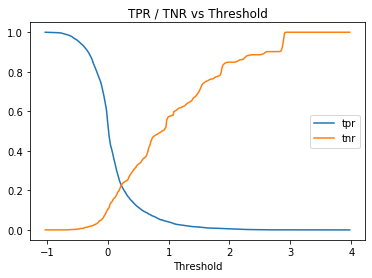

In [10]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

# Choose an appropriate threshold and generate classification report on the train set.

In [11]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('Threshold: {:.4f}, accuracy: {:.4f}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print('Classification report\n', report)

    Batch 1 / 599
    Batch 2 / 599
    Batch 3 / 599
    Batch 4 / 599
    Batch 5 / 599
    Batch 6 / 599
    Batch 7 / 599
    Batch 8 / 599
    Batch 9 / 599
    Batch 10 / 599
    Batch 11 / 599
    Batch 12 / 599
    Batch 13 / 599
    Batch 14 / 599
    Batch 15 / 599
    Batch 16 / 599
    Batch 17 / 599
    Batch 18 / 599
    Batch 19 / 599
    Batch 20 / 599
    Batch 21 / 599
    Batch 22 / 599
    Batch 23 / 599
    Batch 24 / 599
    Batch 25 / 599
    Batch 26 / 599
    Batch 27 / 599
    Batch 28 / 599
    Batch 29 / 599
    Batch 30 / 599
    Batch 31 / 599
    Batch 32 / 599
    Batch 33 / 599
    Batch 34 / 599
    Batch 35 / 599
    Batch 36 / 599
    Batch 37 / 599
    Batch 38 / 599
    Batch 39 / 599
    Batch 40 / 599
    Batch 41 / 599
    Batch 42 / 599
    Batch 43 / 599
    Batch 44 / 599
    Batch 45 / 599
    Batch 46 / 599
    Batch 47 / 599
    Batch 48 / 599
    Batch 49 / 599
    Batch 50 / 599
    Batch 51 / 599
    Batch 52 / 599
    Batch 53 / 599
  

    Batch 418 / 599
    Batch 419 / 599
    Batch 420 / 599
    Batch 421 / 599
    Batch 422 / 599
    Batch 423 / 599
    Batch 424 / 599
    Batch 425 / 599
    Batch 426 / 599
    Batch 427 / 599
    Batch 428 / 599
    Batch 429 / 599
    Batch 430 / 599
    Batch 431 / 599
    Batch 432 / 599
    Batch 433 / 599
    Batch 434 / 599
    Batch 435 / 599
    Batch 436 / 599
    Batch 437 / 599
    Batch 438 / 599
    Batch 439 / 599
    Batch 440 / 599
    Batch 441 / 599
    Batch 442 / 599
    Batch 443 / 599
    Batch 444 / 599
    Batch 445 / 599
    Batch 446 / 599
    Batch 447 / 599
    Batch 448 / 599
    Batch 449 / 599
    Batch 450 / 599
    Batch 451 / 599
    Batch 452 / 599
    Batch 453 / 599
    Batch 454 / 599
    Batch 455 / 599
    Batch 456 / 599
    Batch 457 / 599
    Batch 458 / 599
    Batch 459 / 599
    Batch 460 / 599
    Batch 461 / 599
    Batch 462 / 599
    Batch 463 / 599
    Batch 464 / 599
    Batch 465 / 599
    Batch 466 / 599
    Batch 467 / 599


# Evaluate on test set.

In [12]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'test',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the test dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: test
Number of vertices: 151
Number of static edges: 1888
Number of temporal edges: 37929
Number of examples/datapoints: 21070
--------------------------------
--------------------------------
Computing ROC-AUC score for the test dataset after training.
    Batch 3 / 659: loss 0.6325, accuracy 0.6875
    ROC-AUC score: 0.6445
    Batch 6 / 659: loss 0.6772, accuracy 0.6042
    ROC-AUC score: 0.8455
    Batch 9 / 659: loss 0.6804, accuracy 0.6042
    ROC-AUC score: 0.6478
    Batch 12 / 659: loss 0.7262, accuracy 0.4688
    ROC-AUC score: 0.4251
    Batch 15 / 659: loss 0.6711, accuracy 0.5729
    ROC-AUC score: 0.7733
    Batch 18 / 659: loss 0.6694, accuracy 0.6562
    ROC-AUC 

    Batch 312 / 659: loss 0.6748, accuracy 0.5833
    ROC-AUC score: 0.7302
    Batch 315 / 659: loss 0.6412, accuracy 0.7083
    ROC-AUC score: 0.8471
    Batch 318 / 659: loss 0.6629, accuracy 0.6250
    ROC-AUC score: 0.7328
    Batch 321 / 659: loss 0.6901, accuracy 0.5938
    ROC-AUC score: 0.7328
    Batch 324 / 659: loss 0.6803, accuracy 0.5938
    ROC-AUC score: 0.8528
    Batch 327 / 659: loss 0.6463, accuracy 0.6458
    ROC-AUC score: 0.6802
    Batch 330 / 659: loss 0.6835, accuracy 0.4896
    ROC-AUC score: 0.6478
    Batch 333 / 659: loss 0.6216, accuracy 0.6771
    ROC-AUC score: 0.7539
    Batch 336 / 659: loss 0.6142, accuracy 0.6979
    ROC-AUC score: 0.8300
    Batch 339 / 659: loss 0.6305, accuracy 0.6667
    ROC-AUC score: 0.6875
    Batch 342 / 659: loss 0.6749, accuracy 0.5729
    ROC-AUC score: 0.6745
    Batch 345 / 659: loss 0.6500, accuracy 0.6979
    ROC-AUC score: 0.7137
    Batch 348 / 659: loss 0.7085, accuracy 0.5938
    ROC-AUC score: 0.7773
    Batch 35

    Batch 642 / 659: loss 0.6197, accuracy 0.6250
    ROC-AUC score: 0.7460
    Batch 645 / 659: loss 0.6829, accuracy 0.6354
    ROC-AUC score: 0.7143
    Batch 648 / 659: loss 0.6799, accuracy 0.5833
    ROC-AUC score: 0.5412
    Batch 651 / 659: loss 0.6233, accuracy 0.6771
    ROC-AUC score: 0.8095
    Batch 654 / 659: loss 0.6400, accuracy 0.6354
    ROC-AUC score: 0.7100
    Batch 657 / 659: loss 0.6413, accuracy 0.6458
    ROC-AUC score: 0.7569
Loss 0.6504, accuracy 0.6306
ROC-AUC score: 0.7171
Classification report
               precision    recall  f1-score   support

         0.0       0.67      0.53      0.59     10535
         1.0       0.61      0.74      0.67     10535

    accuracy                           0.63     21070
   macro avg       0.64      0.63      0.63     21070
weighted avg       0.64      0.63      0.63     21070

Finished testing.
--------------------------------
